In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime 
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
plt.style.use('fivethirtyeight')

### 配對交易所需三個時間序列的統計條件：

### 1. 相關性（Correlation）

### 2. 共整合性（Cointegration）

### 3. 平穩性（Stationary）

In [2]:
mu, sigma = 0, 0.1
X=np.random.normal(mu,sigma,100)
Y=np.array([x+0.0001*t for t,x in enumerate(X)])
print(np.corrcoef(X,Y))

[[1.         0.99942521]
 [0.99942521 1.        ]]


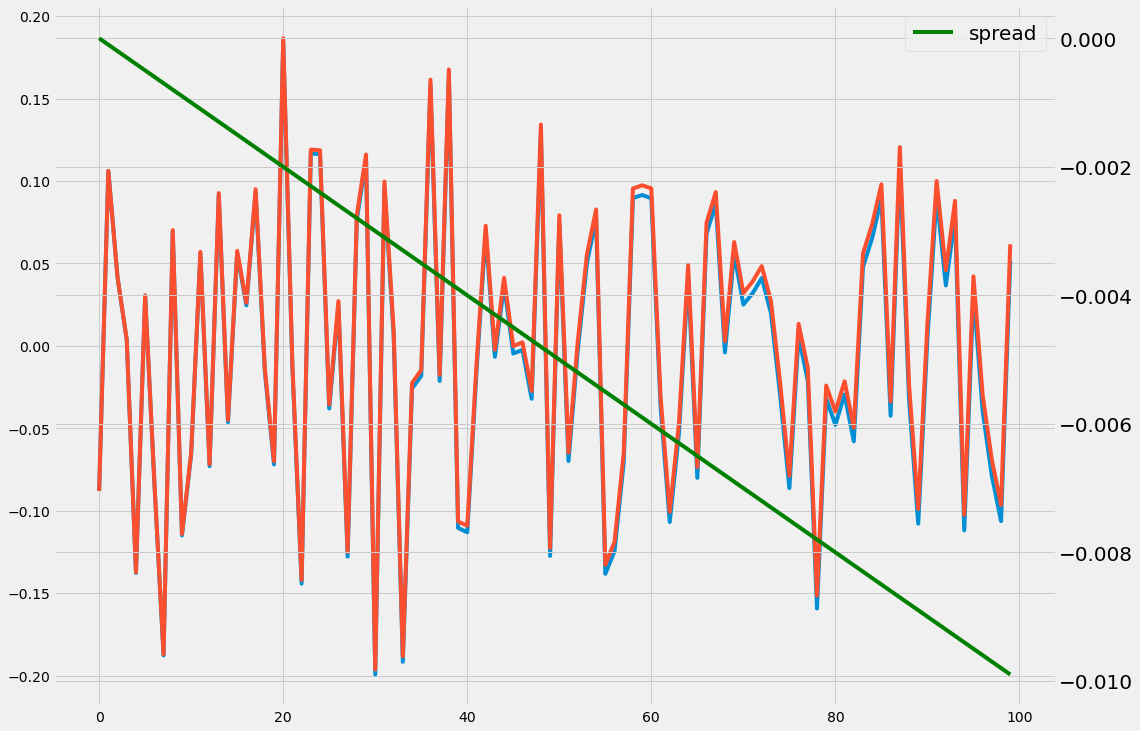

In [3]:
df=pd.DataFrame({'X':X,'Y':Y})
df['spread']=df['X']-df["Y"]
plt.figure(figsize=(16,12))
plt.plot(df['X'])
plt.plot(df['Y'])
plt.twinx()
plt.plot(df['spread'],color='g')
plt.legend(['spread'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### 相關性 $\neq$ 共整合性 !!

### 共整合的主要概念為兩序列經過線性組合(加減乘除後)可以變成定態的時間序列(穩定的在均線軸上震盪) 

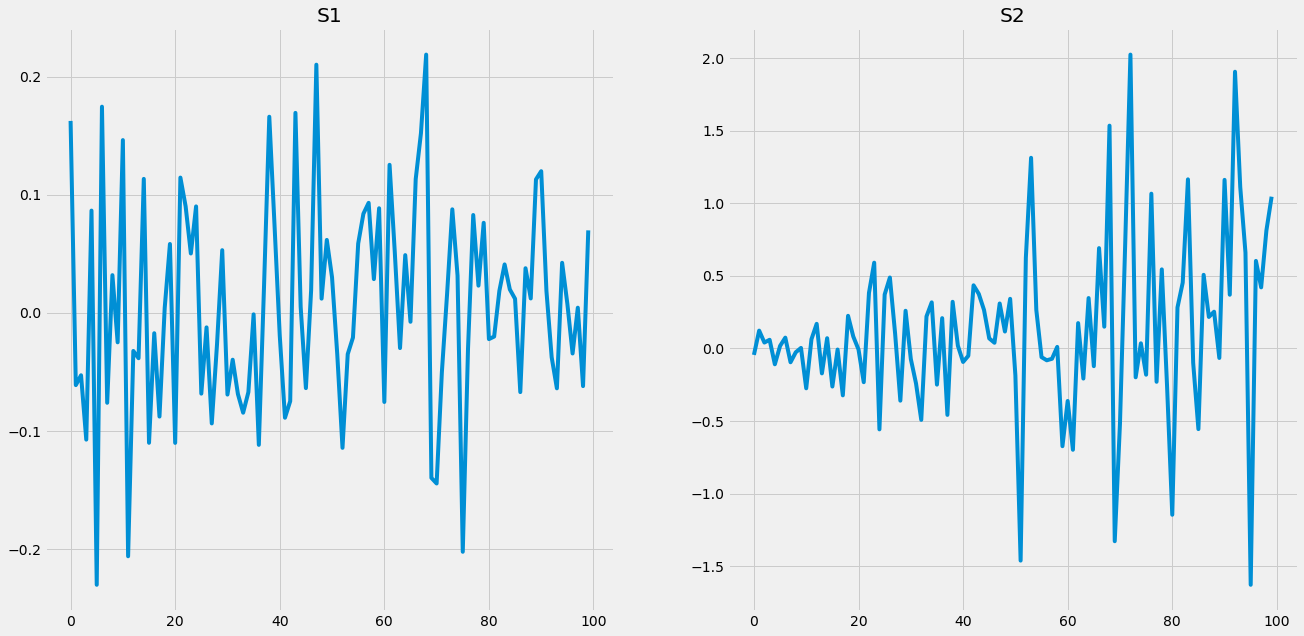

In [4]:
np.random.seed(1)
S1=np.random.normal(0,0.1,100)
S2=np.array([])
for x in range(10):
    S_tem=np.random.normal(0,0.1*(x+1),10)
    S2=np.append(S2,S_tem)
fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].plot(S1)
ax[0].set_title('S1')
ax[1].plot(S2)
ax[1].set_title('S2')
plt.show()

### 左邊是定態時間序列，右邊是非定態時間序列

### Loading data

### 用台積電(2330)、聯發科（2454）做配對交易

In [5]:
TSMC=pd.read_csv('data/2330.TW.csv')[['Date','Close']]
MT=pd.read_csv('data/2454.TW.csv')[['Date','Close']]
TSMC.columns=['Date','TSMC']
MT.columns=['Date','MT']
prices=pd.merge(TSMC,MT,on='Date')

In [6]:
prices

,Date,TSMC,MT
0,2017-12-06,227.0,286.5
1,2017-12-07,226.5,287.5
2,2017-12-08,227.0,296.0
3,2017-12-11,227.5,299.5
4,2017-12-12,227.5,296.0
...,...,...,...
1214,2022-11-29,487.0,713.0
1215,2022-11-30,490.0,733.0
1216,2022-12-01,498.5,741.0
1217,2022-12-02,492.5,739.0


In [7]:
len(prices)

1219

### 本次報告所回測的時間為 2017-12-06 ~ 2022-12-05，共1219個交易日。

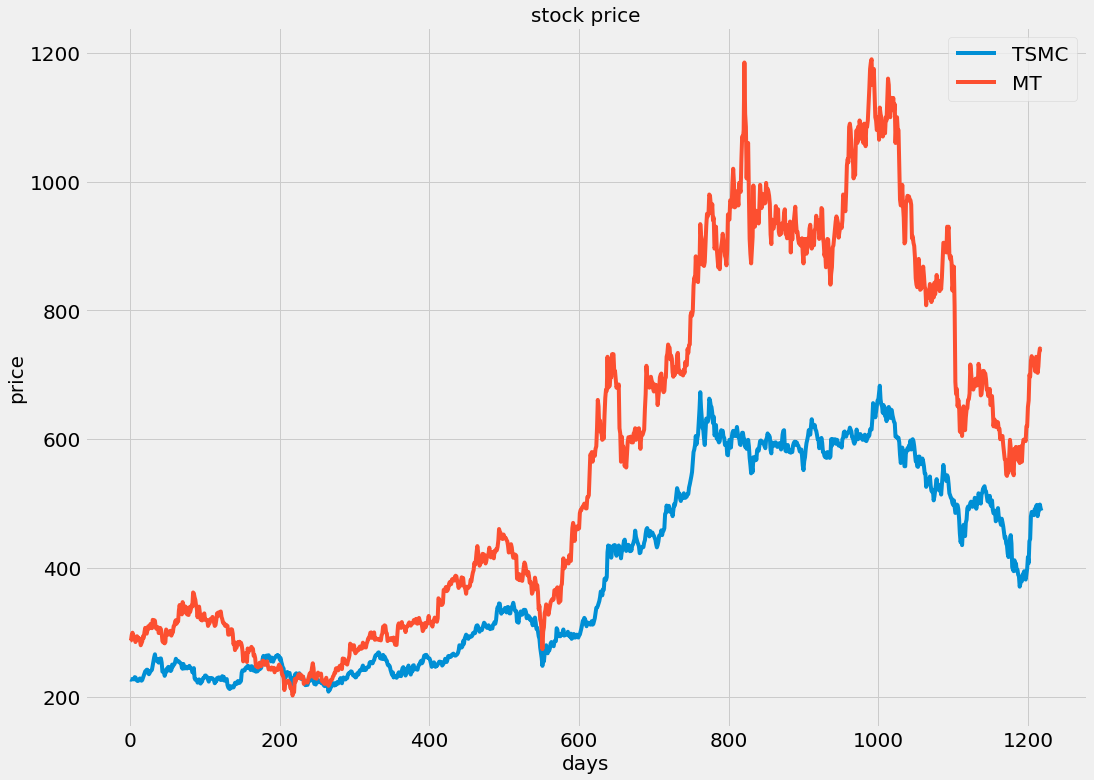

In [8]:
plt.figure(figsize=(16,12))
plt.plot(TSMC[['TSMC']])
plt.plot(MT[['MT']])
plt.title('stock price',fontsize=20)
plt.legend(['TSMC','MT'], fontsize=20,title_fontsize=20)
plt.xlabel('days',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Variance-covariance matrix

In [9]:
# 計算日報酬率
prices_pct=prices[['TSMC','MT']].pct_change(1)
prices_pct.corr()

,TSMC,MT
TSMC,1.000000,0.505825
MT,0.505825,1.000000


### 兩者股票的時間序列為中度相關性（Correlation）。

### ADF Test


利用 ADF 檢定檢查每支股票是否為 nonstationary，並對其做一期差分，再檢查是否為 stationary 的資料，若一期差分為 stationary，則為共整合關係檢定的資料，適合進行配對交易。假設檢定為:

### $H_0$ : 價差走勢為 nonstationary       v.s.      $H_1$ : 價差走勢為 stationary

In [10]:
prices_change_TSMC=prices[['TSMC']].diff()
prices_change_TSMC=prices_change_TSMC.dropna()
adfuller(prices_change_TSMC)

(-21.006667236942402,
 0.0,
 2,
 1215,
 {'1%': -3.435743555099632,
  '5%': -2.8639217381867486,
  '10%': -2.568038075665972},
 8090.182647499236)

In [11]:
prices_change_MT=prices[['MT']].diff()
prices_change_MT=prices_change_MT.dropna()
adfuller(prices_change_MT)

(-35.186250608297804,
 0.0,
 0,
 1217,
 {'1%': -3.4357346726088136,
  '5%': -2.863917819294165,
  '10%': -2.568035988607032},
 10079.057570547931)

### 兩支股票都通過檢定拒絕對立假設，差分序列為定態序列。

### 我們希望找到合適的比例 $c$，使得：
### $$ P_A \approx c \times P_B$$
### $$ \Rightarrow s=P_A - c \times P_B$$
### $$ \Rightarrow P_A= s+ c \times P_B$$
### 用歷史資料做最小平方法(OLS)來找出合適投資組合的 $c$ 與 $s$ 。

In [12]:
TSMC_train=prices[["Date","TSMC"]].head(1000)
MT_train=prices[["Date","MT"]].head(1000)
S1=sm.add_constant(TSMC_train['TSMC'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:
TSMC_test=prices[["Date","TSMC"]].iloc[1000:]
MT_test=prices[["Date","MT"]].iloc[1000:]
Spread=prices[['Date']]

In [14]:
result=sm.OLS(MT_train['MT'],S1).fit()

In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MT   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 2.606e+04
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:02:38   Log-Likelihood:                -5410.6
No. Observations:                1000   AIC:                         1.083e+04
Df Residuals:                     998   BIC:                         1.084e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -151.6067      4.536    -33.426      0.000    -160.507    -142.706
TSMC           1.8394      0.011    161.426      0.000       1.817       1.862
==============================================================================
Omnibus:                       91.835   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.143
Skew:                           0.703   Prob(JB):                     5.49e-29
Kurtosis:                       4.071   Cond. No.                     1.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### $$P_{MT}= -151.6067 + 1.8394 \times P_{TSMC}$$

### 找尋回歸的誤差（$Y-\hat{Y}$）：偏誤的定價
### 我們期待偏誤的誤差會回復到0，而這段期間正是配對交易的時機。

In [16]:
Spread['spread']=prices['MT']-result.params['TSMC']*prices['TSMC']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


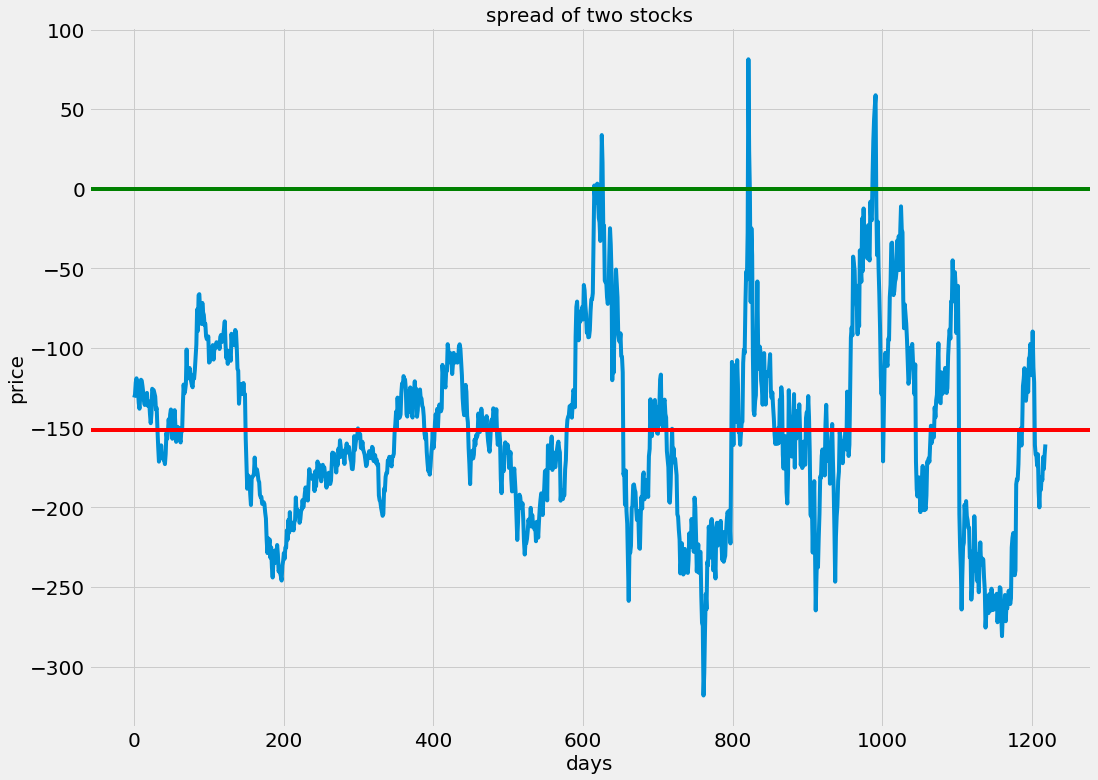

In [17]:
plt.figure(figsize=(16,12))
plt.plot(Spread['spread'])
plt.title('spread of two stocks',fontsize=20)
plt.axhline(y=result.params[0],color="r",linestyle='-')
plt.axhline(y=0,color="g",linestyle='-')
plt.xlabel('days',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### spread 的橫軸原點調整至 s=−151.6067，平移新的水平軸。

In [18]:
Spread['spread']=prices['MT']-result.params['TSMC']*prices['TSMC']-result.params['const']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


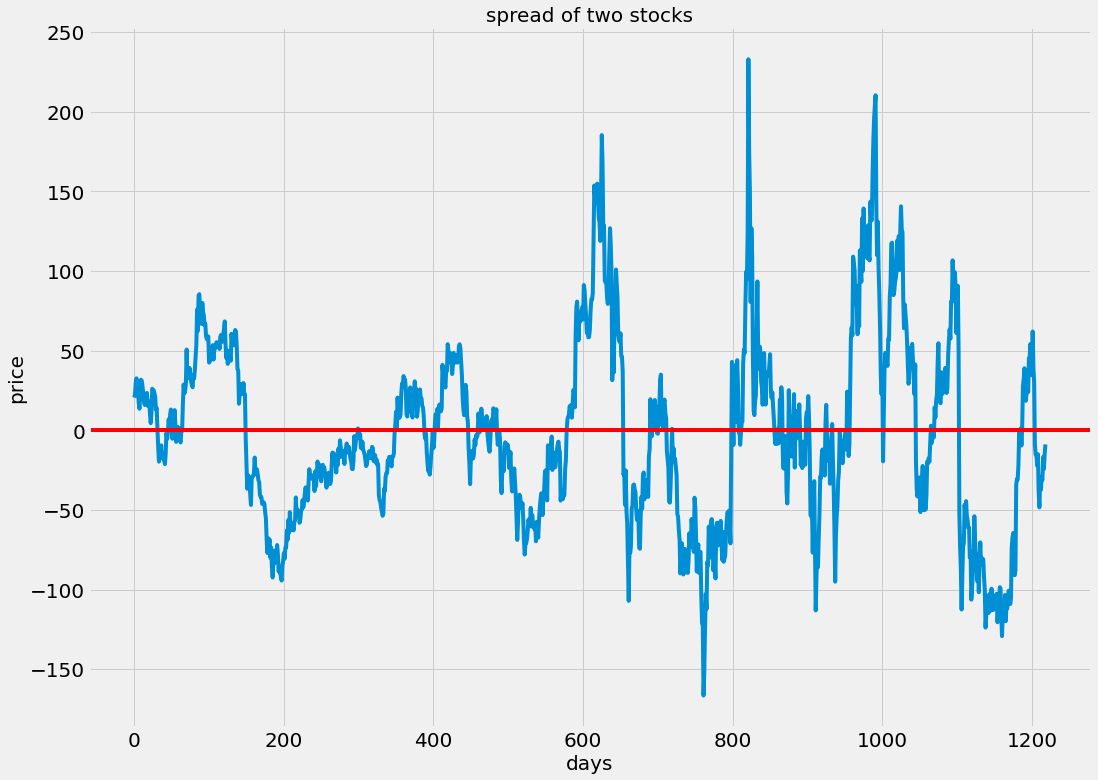

In [19]:
plt.figure(figsize=(16,12))
plt.plot(Spread['spread'])
plt.title('spread of two stocks',fontsize=20)
plt.axhline(y=0,color="r",linestyle='-')
plt.xlabel('days',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### 假設 $A_t$ 與 $B_t$ 之間為一度共整合，則存在 $\gamma$ 使得
### $$ \Rightarrow u_t = A_t - \gamma B_t$$
### 為一定態的序列且 $\mathbb{E}(u_t)=0$。

### Shapiro-Wilk Test 常態性檢定

### $H_0$ : sample is from the normal distributions.  v.s. $H_1$ : sample isn't from the normal distributions. 

In [20]:
# conduct the  Shapiro-Wilk Test
shapiro(Spread['spread'])

(0.9870583415031433, 6.303703781185277e-09)

### 拒絕 $H_0$，資料不是常態分佈。

In [21]:
Spread['spread'].mean(),Spread['spread'].std()

(-2.3235583740619945, 57.716430301159726)

# 配對交易（pair trade）演算法:


### 設定「做多一單位的聯發科做空$c$單位的台積電」為一個投資組合，投資組合的殘差為：
### $$ u_t = P_{MT}^t - c \times P_{TSMC}^t-s$$
###  1. 設定觸發交易門檻 $s_0$

### 2. 若 $u_t > s_0$ ，做空投資組合，也就是做空一單位的聯發科做多$c$單位的台積電 (Buy group)

### 3. 若 $u_t < -s_0$ ，做多投資組合，也就是做多一單位的聯發科做空$c$單位的台積電 (Short group)

### 4. 當 $u_t = 0$ ，結清部位。(Buy $ \Rightarrow$ Sell  &  Short $ \Rightarrow $ Cover)

### 設定交易訊號

In [22]:
threshold=93
signals=Spread[['Date']]
signals['buy']=Spread['spread']< -threshold
signals['short']=Spread['spread']> threshold
signals['sell']=(Spread['spread'].shift()<0) & (Spread['spread']>=0)
signals['cover']=(Spread['spread'].shift()>0) & (Spread['spread']<=0)
signals.head()

,Date,buy,short,sell,cover
0,2017-12-06,False,False,False,False
1,2017-12-07,False,False,False,False
2,2017-12-08,False,False,False,False
3,2017-12-11,False,False,False,False
4,2017-12-12,False,False,False,False


In [23]:
def day(x,y):
    return int(str(pd.to_datetime(x)-pd.to_datetime(y)).split(' ')[0])

## 交易成本計算

* 融券買入時：交易手續費0.1425%(未折扣)

* 融券賣出時：交易手續費0.1425%(未折扣)、證券交易稅0.3%、借券費0.08%、融券利息0.2%/年

* 交易手續費算法:

    * 做多: 交割金額*0.1425%
    
    * 做多獲利了結: 交割金額*(0.001425+0.003)
    
    * 放空:交割金額*0.1425%

    * 保證金:交割金額*0.9，若(首次買進交割金額+(保證金+未實現損益))/目前交割金額>130%, 則直接以當前市價斷頭平倉該次交易結束
    
    * 放空獲利了結:交割金額*(0.001425+0.003+0.0008+0.002*(持有天數/360))

### buy-sell group

In [24]:
bs=pd.merge(prices,signals[['Date','buy','sell']],on='Date')
bs=pd.merge(bs,Spread,on='Date')
bs

,Date,TSMC,MT,buy,sell,spread
0,2017-12-06,227.0,286.5,False,False,20.557478
1,2017-12-07,226.5,287.5,False,False,22.477190
2,2017-12-08,227.0,296.0,False,False,30.057478
3,2017-12-11,227.5,299.5,False,False,32.637766
4,2017-12-12,227.5,296.0,False,False,29.137766
...,...,...,...,...,...,...
1214,2022-11-29,487.0,713.0,False,False,-31.192789
1215,2022-11-30,490.0,733.0,False,False,-16.711061
1216,2022-12-01,498.5,741.0,False,False,-24.346166
1217,2022-12-02,492.5,739.0,False,False,-15.309622


In [25]:
tem_spread=0
earn_bs=0
day_buy=[]
day_sell=[]
for i in range(1,bs.shape[0]):
    if tem_spread==0:  
        if (bs['buy'][i-1]==False) & (bs['buy'][i]==True):
            tem_spread=bs['MT'][i]*(1+0.001425)-result.params['TSMC']*bs['TSMC'][i]*(1-0.001425)
            day_buy.append(i)
            date_buy=bs["Date"][i]
    else:
        if (bs['sell'][i-1]==False) & (bs['sell'][i]==True):
            sell_spread=bs['MT'][i]*(1-0.004425)-result.params['TSMC']*bs['TSMC'][i]*(1+(0.005225+0.002*day(bs["Date"][i],date_buy)/360))
            earn_bs+=(sell_spread-tem_spread)
            print('buy:',tem_spread,'sell:',sell_spread,'accumulated earn:',earn_bs)
            tem_spread=0
            day_sell.append(i)
day_buy=day_buy[0:len(day_sell)]
earn_bs

buy: -244.90863742165536 sell: -154.2958123315688 accumulated earn: 90.61282509008655
buy: -256.74534835930183 sell: -139.9318280022751 accumulated earn: 207.42634544711328
buy: -252.7073074638297 sell: -118.79994407934305 accumulated earn: 341.3337088315999
buy: -261.7458451908095 sell: -158.4918907881331 accumulated earn: 444.5876632342763
buy: -243.8605295395971 sell: -137.6032713433059 accumulated earn: 550.8449214305675
buy: -261.88177980574915 sell: -157.3033083406035 accumulated earn: 655.4233928957132


655.4233928957132

### 買進（Buy）在相對低點，賣在（Sell）在相對高點。

### signal of buy and sell

In [26]:
trade_bs=np.zeros(prices.shape[0])
for i in range(len(day_buy)):
    trade_bs[day_buy[i]:day_sell[i]+1]=np.ones(day_sell[i]+1-day_buy[i])
df_trade_bs=pd.DataFrame({'trade_bs':trade_bs})

### short-cover group

In [27]:
sc=pd.merge(prices,signals[['Date','short','cover']],on='Date')
sc=pd.merge(sc,Spread,on='Date')
sc

,Date,TSMC,MT,short,cover,spread
0,2017-12-06,227.0,286.5,False,False,20.557478
1,2017-12-07,226.5,287.5,False,False,22.477190
2,2017-12-08,227.0,296.0,False,False,30.057478
3,2017-12-11,227.5,299.5,False,False,32.637766
4,2017-12-12,227.5,296.0,False,False,29.137766
...,...,...,...,...,...,...
1214,2022-11-29,487.0,713.0,False,False,-31.192789
1215,2022-11-30,490.0,733.0,False,False,-16.711061
1216,2022-12-01,498.5,741.0,False,False,-24.346166
1217,2022-12-02,492.5,739.0,False,False,-15.309622


In [28]:
tem_spread=0
earn_sc=0
day_short=[]
day_cover=[]
for i in range(1,bs.shape[0]):
    if tem_spread==0:  
        if (sc['short'][i-1]==False) & (sc['short'][i]==True):
            tem_spread=sc['MT'][i]*(1-0.001425)-result.params['TSMC']*sc['TSMC'][i]*(1+0.001425)
            day_short.append(i)
            date_short=sc["Date"][i]
    else:
        if (sc['cover'][i-1]==False) & (sc['cover'][i]==True):
            cover_spread=sc['MT'][i]*(1+(0.005225+0.002*day(bs["Date"][i],date_short)/360))-result.params['TSMC']*sc['TSMC'][i]*(1-0.004425)
            earn_sc+=(-cover_spread+tem_spread)
            print('short:',tem_spread,'cover:',cover_spread,'accumulated earn:',earn_sc)
            tem_spread=0
            day_cover.append(i)
day_short=day_short[0:len(day_cover)]
earn_sc

short: -34.10129148081364 cover: -172.51676261552518 accumulated earn: 138.41547113471154
short: -55.17237258599812 cover: -144.55680207047965 accumulated earn: 227.79990061919307
short: -45.71988343478165 cover: -159.72141109153108 accumulated earn: 341.8014282759425
short: -37.62491409333893 cover: -161.6182599820114 accumulated earn: 465.794774164615
short: -47.609249951768675 cover: -196.43891239698144 accumulated earn: 614.6244366098277


614.6244366098277

### 賣空（Short）在相對高點，回補（Cover）在相對低點。

### signal of short and cover

In [29]:
trade_sc=np.zeros(prices.shape[0])
for i in range(len(day_short)):
    trade_sc[day_short[i]:day_cover[i]+1]=np.ones(day_cover[i]+1-day_short[i])
df_trade_sc=pd.DataFrame({'trade_sc':trade_sc})

### 一單位的投資組合下所賺取的金額

In [30]:
earn_bs+earn_sc

1270.047829505541

### Find optimal threshold

In [31]:
threshold_set=[i for i in range(1,300)]
earn_bs_set=[]
earn_sc_set=[]
total_earn_set=[]

for i in range(len(threshold_set)):
    threshold=threshold_set[i]
    signals=Spread[['Date']]
    signals['buy']=Spread['spread']< -threshold
    signals['short']=Spread['spread']> threshold
    signals['sell']=(Spread['spread'].shift()<0) & (Spread['spread']>=0)
    signals['cover']=(Spread['spread'].shift()>0) & (Spread['spread']<=0)
    signals.head()
    
    
    # buy-sell group
    
    bs=pd.merge(prices,signals[['Date','buy','sell']],on='Date')
    bs=pd.merge(bs,Spread,on='Date')
    
    tem_spread=0
    earn_bs=0
    for i in range(1,bs.shape[0]):
        if tem_spread==0:  
            if (bs['buy'][i-1]==False) & (bs['buy'][i]==True):
                tem_spread=bs['MT'][i]*(1+0.001425)-result.params['TSMC']*bs['TSMC'][i]*(1-0.001425)
                day_buy.append(i)
                date_buy=bs["Date"][i]
        else:
            if (bs['sell'][i-1]==False) & (bs['sell'][i]==True):
                sell_spread=bs['MT'][i]*(1-0.004425)-result.params['TSMC']*bs['TSMC'][i]*(1+(0.005225+0.002*day(bs["Date"][i],date_buy)/360))
                earn_bs+=(sell_spread-tem_spread)
                tem_spread=0
                day_sell.append(i)
    earn_bs_set.append(earn_bs)
    
    
    
    # short-cover group
    sc=pd.merge(prices,signals[['Date','short','cover']],on='Date')
    sc=pd.merge(sc,Spread,on='Date')
    
    tem_spread=0
    earn_sc=0
    for i in range(1,sc.shape[0]):
        if tem_spread==0:  
            if (sc['short'][i-1]==False) & (sc['short'][i]==True):
                tem_spread=sc['MT'][i]*(1-0.001425)-result.params['TSMC']*sc['TSMC'][i]*(1+0.001425)
                day_short.append(i)
                date_short=sc["Date"][i]
        else:
            if (sc['cover'][i-1]==False) & (sc['cover'][i]==True):
                cover_spread=sc['MT'][i]*(1+(0.005225+0.002*day(bs["Date"][i],date_short)/360))-result.params['TSMC']*sc['TSMC'][i]*(1-0.004425)
                earn_sc+=(-cover_spread+tem_spread)
                tem_spread=0
                day_cover.append(i)
    earn_sc_set.append(earn_sc)
    
    total_earn_set.append(earn_bs+earn_sc)


In [32]:
index=total_earn_set.index(max(total_earn_set))
print('threshold:',threshold_set[index],'  ','profit:',max(total_earn_set))

threshold: 93    profit: 1270.047829505541


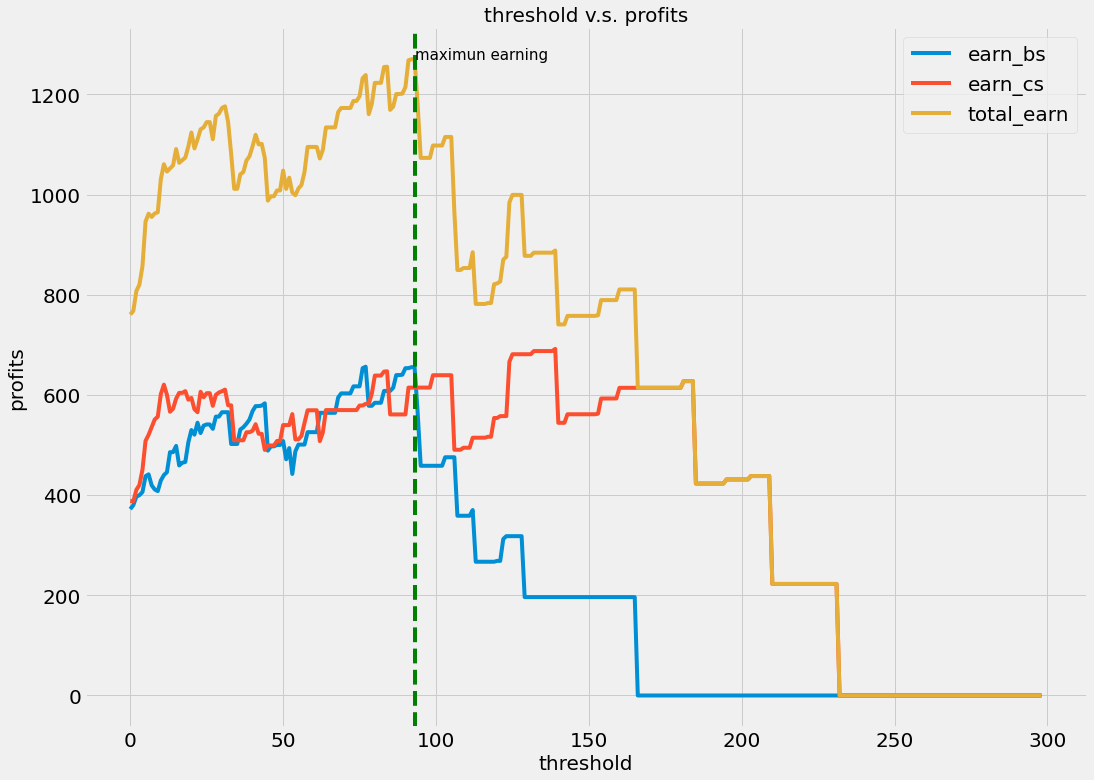

In [33]:
df_earn=pd.DataFrame({'earn_bs':earn_bs_set,'earn_sc':earn_sc_set,'total_earn':total_earn_set})
plt.figure(figsize=(16,12))
plt.plot(df_earn)
plt.title('threshold v.s. profits',fontsize=20)
plt.legend(['earn_bs','earn_cs','total_earn'], fontsize=20,title_fontsize=20)
plt.axvline(x=threshold_set[index],color="g",linestyle='--')
plt.xlabel('threshold',fontsize=20)
plt.ylabel('profits',fontsize=20)
plt.annotate('maximun earning',(threshold_set[index],max(total_earn_set)),fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

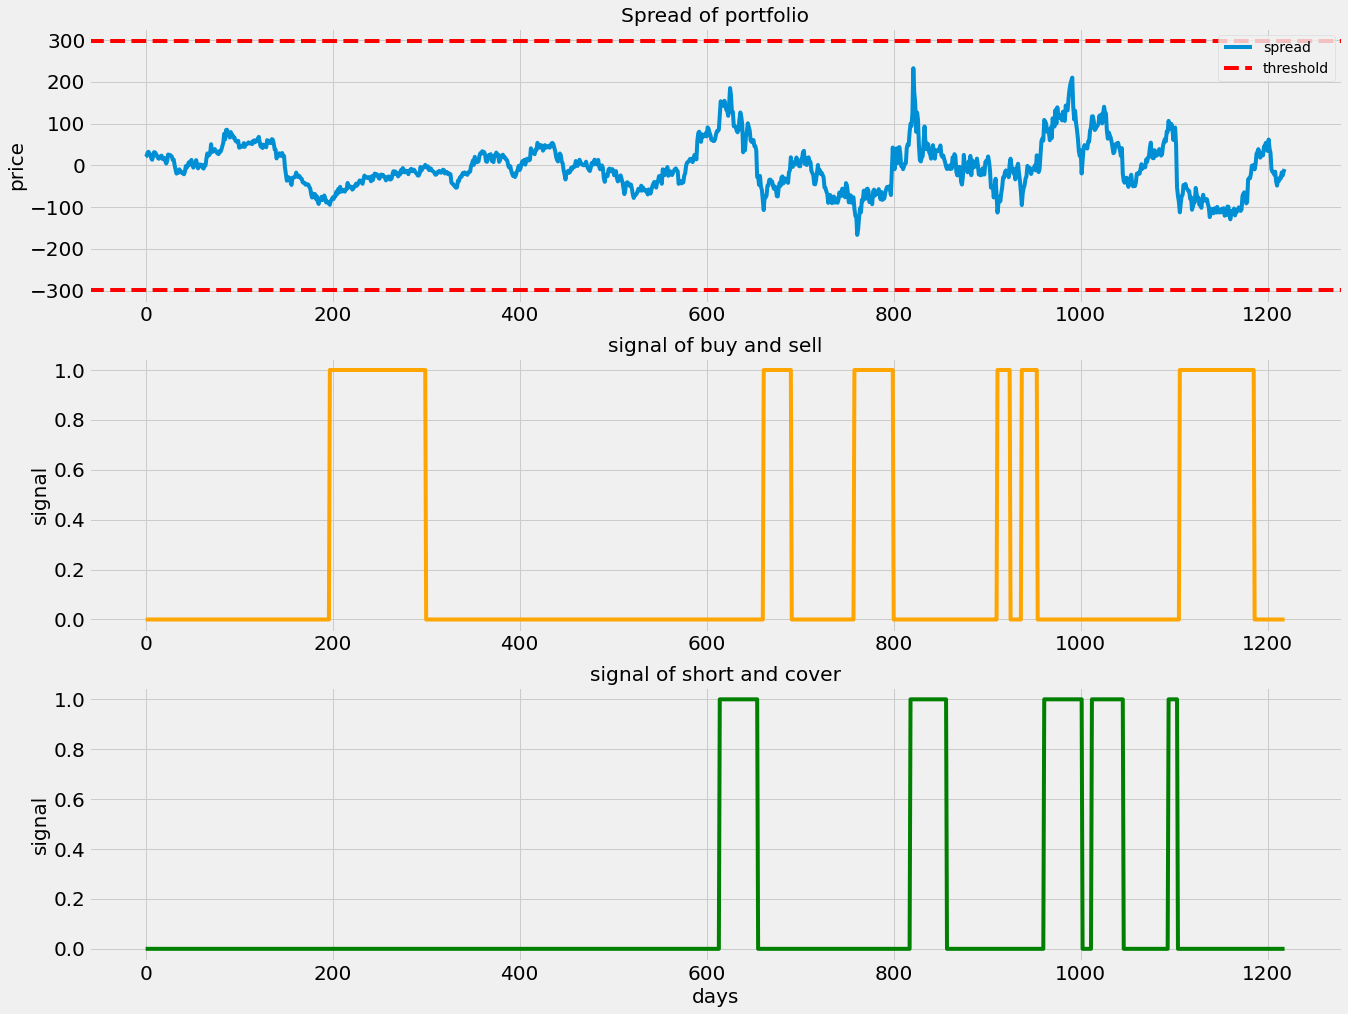

In [34]:
fig=plt.figure(figsize=(20,16))
ax1=fig.add_subplot(311)
ax1.plot(Spread[['spread']])
plt.axhline(y=-threshold,color="r",linestyle='--')
plt.axhline(y=threshold,color="r",linestyle='--')
plt.legend(['spread','threshold'])
plt.title('Spread of portfolio')
plt.ylabel('price',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1=fig.add_subplot(312)
ax1.plot(df_trade_bs,color='orange')
plt.title('signal of buy and sell')
plt.ylabel('signal',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1=fig.add_subplot(313)
ax1.plot(df_trade_sc,color='g')
plt.title('signal of short and cover')
plt.ylabel('signal',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('days',fontsize=20)
plt.show()